## Understanding Residual Connections

### Loading Prequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from tqdm.auto import tqdm
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

### Loading Data

In [2]:
path = r'C:\Users\SUSHANT\Documents\ml_dl_learning\datasets\mnist_train.csv'
df = pd.read_csv(path)
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,60000.0,4.453933,2.88927,0.0,2.0,4.0,7.0,9.0
1x1,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1x2,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1x3,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
1x4,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
28x24,60000.0,0.002000,0.34660,0.0,0.0,0.0,0.0,62.0
28x25,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
28x26,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
28x27,60000.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0


#### visualizing an example

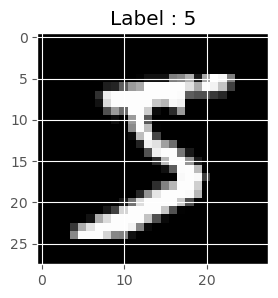

In [5]:
data = df.to_numpy()
plt.figure(figsize=(3, 3))
plt.imshow(data[0,1:].reshape(28, 28), cmap='gray')
plt.title(f'Label : {data[0,0]}')
plt.show()

### Scaling

In [6]:
class StandardScaler:
    def fit(self, data, axis):
        self.mean = np.mean(data, axis, keepdims=True)
        self.std = np.std(data, axis, keepdims=True)
    
    def transform(self, data):
        return (data - self.mean) / self.std
    
    def inverse_transform(self, data):
        return data * self.std + self.mean

scaler = StandardScaler()
scaler.fit(data[:,1:], axis=-1)
sc_data = scaler.transform(data)

In [7]:
print(
    f'For first example:'
    f'\nmaximum of unscaled data: {np.max(data, axis=-1)[0]}',
    f'\nmaximum of scaled data: {np.max(sc_data, axis=-1)[0]}',
)


For first example:
maximum of unscaled data: 255 
maximum of scaled data: 2.760763524


### Dataloading

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, scaler):
        self.data = data
        self.scaler = scaler
    
    def __len__(self):
        return self.data.shape[-1]

    def __getitem__(self, index):
        x = data[index,1:]
        y = data[index,0]
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
        return x, y
    
data = df.to_numpy()
dataset = CustomDataset(data, scaler)
print(
    f'sample input: {dataset[0][0].shape}'
    f'\nsample label shape : {dataset[0][1].shape}'
)

sample input: torch.Size([784])
sample label shape : torch.Size([])


### Model

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation) -> None:
        super(MLP, self).__init__()
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        
        self.in_proj = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        self.get_hidden_layers(hidden_dim, num_layers)
        self.out_proj = nn.Linear(hidden_dim, output_dim)
    
    def get_hidden_layers(self, hidden_dim, num_layers):
        for _ in range(num_layers):
            self.layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                self.activation
                ])

    def forward(self, x):
        x = self.in_proj(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out_proj(x)
        return x


num_classes = np.unique(data[:, 0])
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=4, activation='sigmoid')
print(
    f'model output shape : {model(dataset[0][0]).shape}',
    f'\nnum parameters in model : {sum(p.numel() for p in model.parameters())}'
    )

model output shape : torch.Size([10]) 
num parameters in model : 17590


### Trainer

In [10]:
class Trainer:
    def __init__(self, model, optimizer, dataset, batch_size, epochs):
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        
        self.device = next(model.parameters()).device
        
        self.loss_dict = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        self.grad_state = []
        self.act_state = []
    
    def get_dataloader(self, split):
        train_ds, val_ds = random_split(self.dataset, [0.8, 0.2])
        if split == 'train':
            return DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        elif split == 'val':
            return DataLoader(val_ds, batch_size=self.batch_size, shuffle=False)
        
    def evaluate_accuracy(self, y, y_pred):
        with torch.inference_mode():
            y_probs = F.softmax(y_pred, dim=-1)
            y_probs = torch.argmax(y_probs, dim=-1)
        return torch.mean((y == y_probs).float()).item()

    def train_model(self):
        loader = self.get_dataloader('train')
        loss_dict = {'loss': [], 'acc': []}
        self.model.train()
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
            loss.backward()
            self.optimizer.step()
            loss_dict['loss'].append(loss.cpu().item())
            loss_dict['acc'].append(self.evaluate_accuracy(y, y_pred))   
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])

    def eval_model(self):
        loader = self.get_dataloader('val')
        loss_dict = {'loss': [], 'acc': []}
        self.model.eval()
        for x, y in loader:
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                self.model.eval()
                y_pred = self.model(x)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
                loss_dict['loss'].append(loss.cpu().item())
                loss_dict['acc'].append(self.evaluate_accuracy(y, y_pred))     
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])
    

    def get_gradient(self):
        for n, p in model.named_parameters():
            if (p.requires_grad) and ('bias' not in n):
                self.grad_state.append(p.grad.detach().cpu().abs().mean().numpy())
                
    def train(self):
        for epoch in tqdm(range(self.epochs)):
            train_loss, train_acc = self.train_model()
            val_loss, val_acc = self.eval_model()

            self.loss_dict['train_loss'].append(train_loss)
            self.loss_dict['train_acc'].append(train_acc)
            self.loss_dict['val_loss'].append(val_loss)
            self.loss_dict['val_acc'].append(val_acc)
            self.get_gradient()  
            
            
            if epoch % (self.epochs /10) == 0:
                gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                print(f'Epochs : {epoch} | train loss : {train_loss:.4f} | val loss : {val_loss:.4f} |',
                      f'train_acc : {train_acc:.4f} | val_acc : {val_acc:.4f} | gpu usage : {gpu_usage}')
                
    def plot_results(self, **kwargs):
        ylim = kwargs.get('ylim')
        if ylim is None:
            ylim = 0.1
        
        self.grad_state = np.array(self.grad_state).reshape(-1, self.epochs).transpose(-1, -2)
       
        fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
        
        for i in range(0, 4, 2):
            axs[0].plot(np.arange(self.epochs), list(self.loss_dict.values())[i], label = list(self.loss_dict.keys())[i])
            axs[1].plot(np.arange(self.epochs), list(self.loss_dict.values())[i+1], label = list(self.loss_dict.keys())[i+1])
        axs[0].set_title('Train and Validation Loss')
        axs[0].set_ylabel('Cross - Entropy')
        axs[0].legend(loc="upper right")
        
        axs[1].set_title('Train and Validation Accuracy')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(loc="upper right")

        axs[2].plot(self.grad_state, label=[f'layer{i}' for i in range(self.grad_state.shape[-1])])
        axs[2].set_xlabel('Epochs')
        axs[2].legend(loc="upper right")
        axs[2].set_title('Gradient Flow')
        axs[2].set_ylim([0, ylim])
        plt.tight_layout()
        plt.show();

`Note`: Since, residual connections are being explored, **SGD** is used as default. Stronger optimizer like Adam will lead to convergernce of all models disccussed later.

### Shallow vs Deeper Network

Universal Approximation Theorem: https://en.wikipedia.org/wiki/Universal_approximation_theorem
<br><br>
The Universal Approximation Theorem states that a feed-forward neural network with a single hidden layer and a finite number of nodes can approximate any continuous function to any degree of accuracy. The only constraint is that the range of input values will be fixed for a given neural network weights and biases. <br>
But in practise deeper networks tend to learn better than shallow networks as seen in mordern architectures . <br>
In this section the validity of this notion that deeper network are better learners is challenged.


#### Shallow Network

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs : 0 | train loss : 16.1201 | val loss : 2.7939 | train_acc : 0.1249 | val_acc : 0.1699 | gpu usage : 0.0
Epochs : 10 | train loss : 1.4629 | val loss : 1.3850 | train_acc : 0.5145 | val_acc : 0.5236 | gpu usage : 0.0
Epochs : 20 | train loss : 0.9802 | val loss : 0.8937 | train_acc : 0.6532 | val_acc : 0.7214 | gpu usage : 0.0
Epochs : 30 | train loss : 0.7111 | val loss : 0.6424 | train_acc : 0.7691 | val_acc : 0.7465 | gpu usage : 0.0
Epochs : 40 | train loss : 0.5204 | val loss : 0.5336 | train_acc : 0.8323 | val_acc : 0.8357 | gpu usage : 0.0
Epochs : 50 | train loss : 0.4135 | val loss : 0.4257 | train_acc : 0.8835 | val_acc : 0.8724 | gpu usage : 0.0
Epochs : 60 | train loss : 0.2915 | val loss : 0.2726 | train_acc : 0.9268 | val_acc : 0.9092 | gpu usage : 0.0
Epochs : 70 | train loss : 0.2676 | val loss : 0.2236 | train_acc : 0.9187 | val_acc : 0.9554 | gpu usage : 0.0
Epochs : 80 | train loss : 0.2017 | val loss : 0.1792 | train_acc : 0.9520 | val_acc : 0.9632 | gpu usag

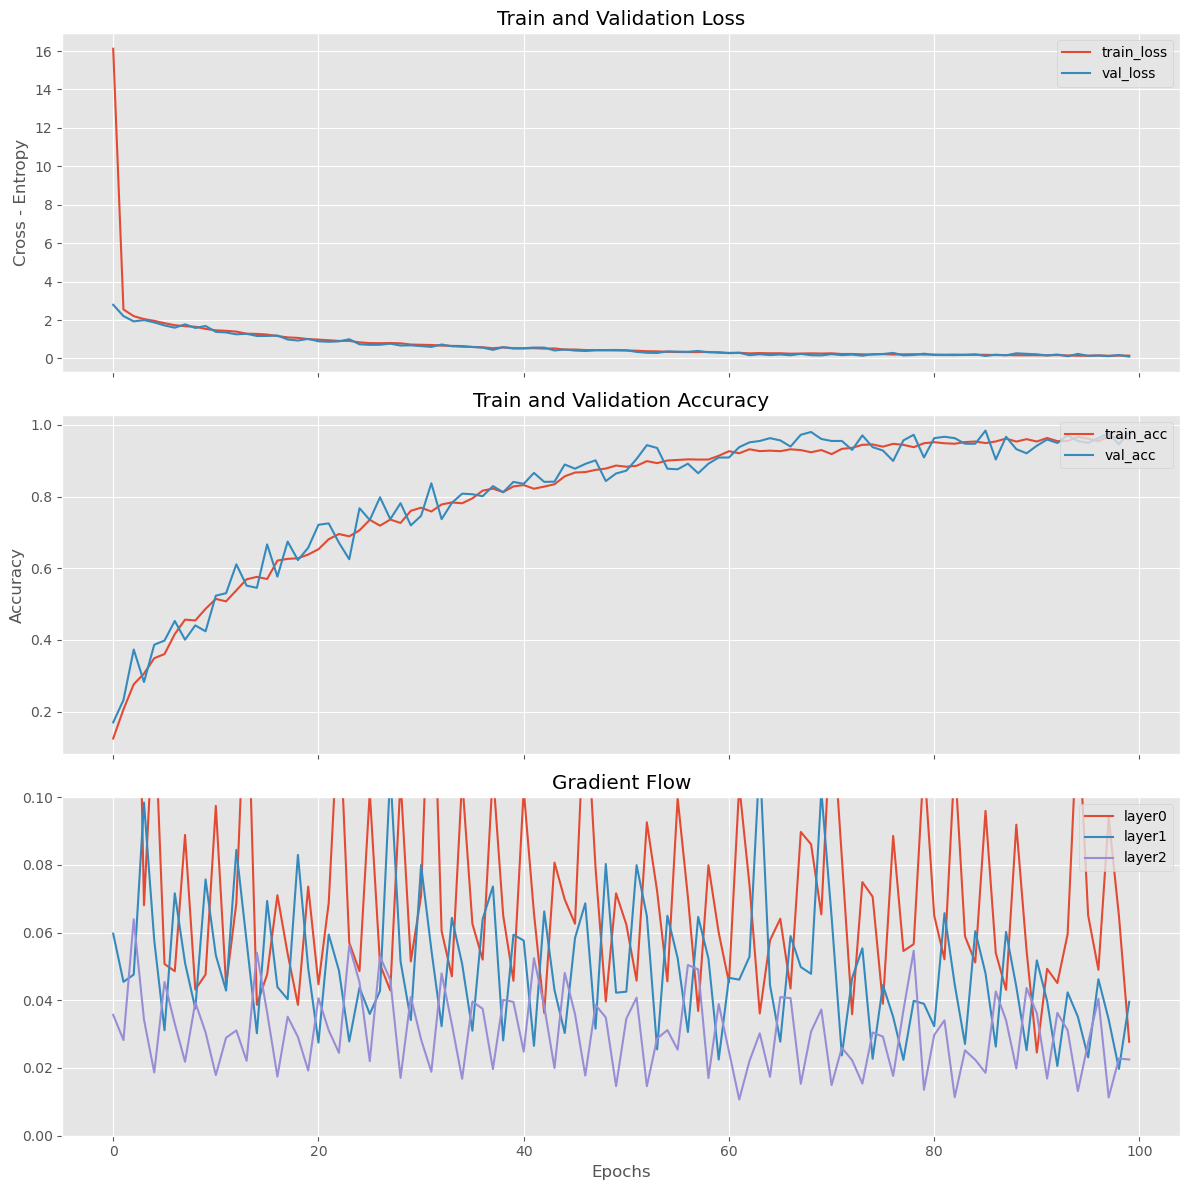

In [11]:
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=1, activation='relu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, dataset, batch_size=128, epochs = 100)
trainer.train()
trainer.plot_results(ylim=0.1)

#### Deeper Network

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs : 0 | train loss : 2.3130 | val loss : 2.3350 | train_acc : 0.1068 | val_acc : 0.1080 | gpu usage : 0.0
Epochs : 10 | train loss : 2.3147 | val loss : 2.3131 | train_acc : 0.1004 | val_acc : 0.0830 | gpu usage : 0.0
Epochs : 20 | train loss : 2.3154 | val loss : 2.3216 | train_acc : 0.1061 | val_acc : 0.1197 | gpu usage : 0.0
Epochs : 30 | train loss : 2.3077 | val loss : 2.3478 | train_acc : 0.1052 | val_acc : 0.1119 | gpu usage : 0.0
Epochs : 40 | train loss : 2.3085 | val loss : 2.2930 | train_acc : 0.1004 | val_acc : 0.0885 | gpu usage : 0.0
Epochs : 50 | train loss : 2.3104 | val loss : 2.2989 | train_acc : 0.0988 | val_acc : 0.1354 | gpu usage : 0.0
Epochs : 60 | train loss : 2.3146 | val loss : 2.3183 | train_acc : 0.1019 | val_acc : 0.0814 | gpu usage : 0.0
Epochs : 70 | train loss : 2.3150 | val loss : 2.3019 | train_acc : 0.0921 | val_acc : 0.1220 | gpu usage : 0.0
Epochs : 80 | train loss : 2.3132 | val loss : 2.3074 | train_acc : 0.0973 | val_acc : 0.0469 | gpu usage

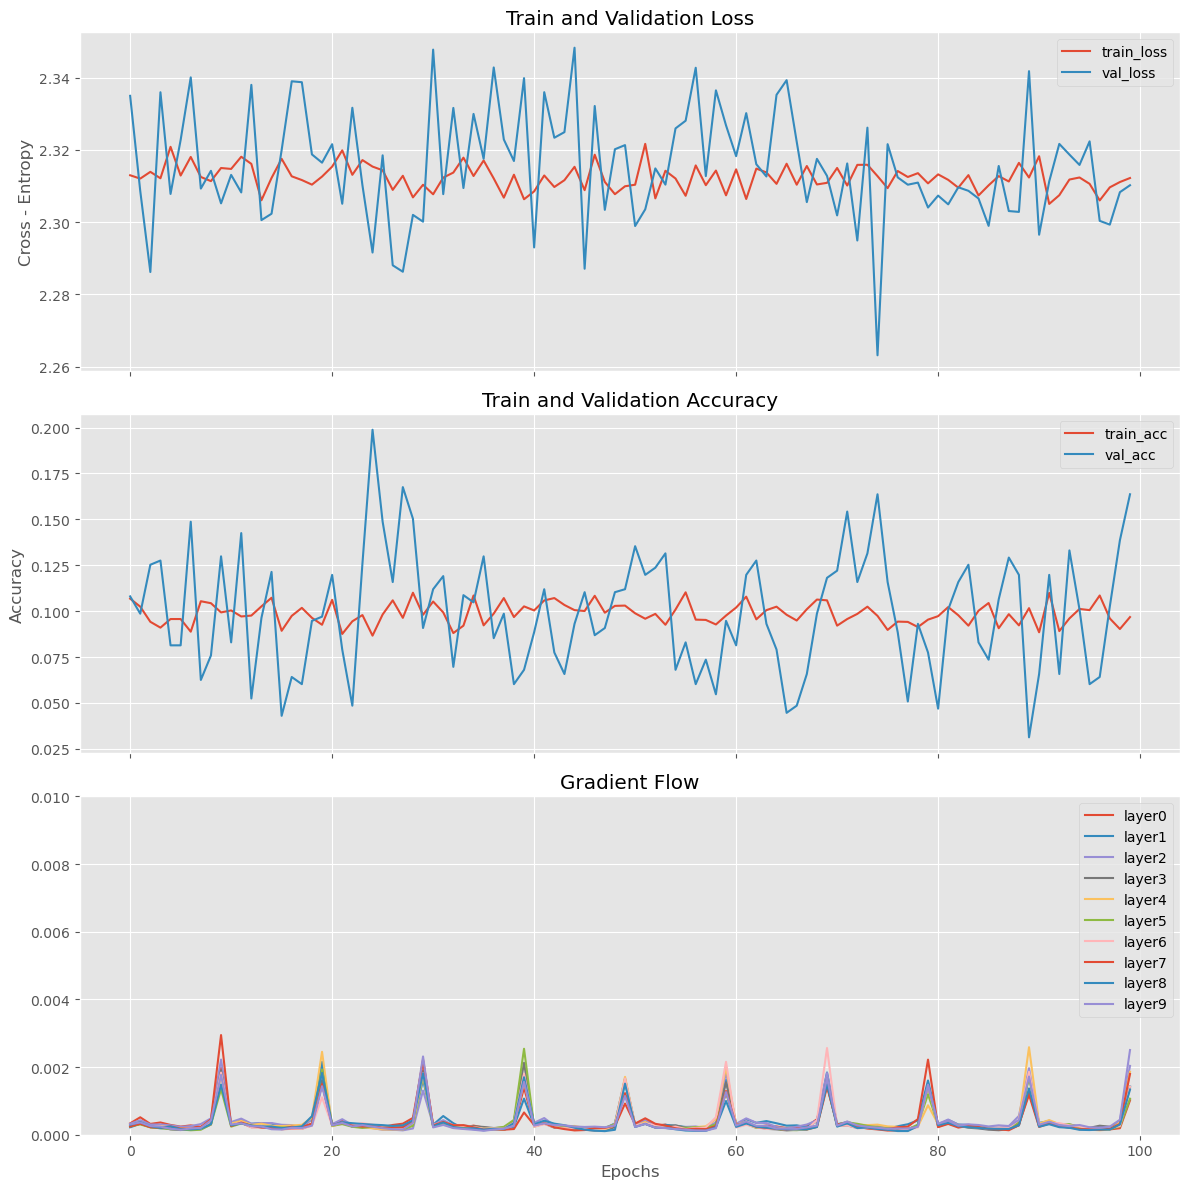

In [12]:
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=8, activation='relu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, dataset, batch_size=128, epochs = 100)
trainer.train()
trainer.plot_results(ylim=0.01)

Here it is observed that model with larger layers do not converge quite nicely.
There are mutliple reasons for theorized for this phenomenon:
- Larger models have more parameters and therefore require more data to learn.
- Larger models also require more time to converge as they has tune more parameters.
- Also correct initialisations play a more important role for training larger models.

Right Initialisation are often difficult to get and can be time/compute consuming.
<br> So, numerous alternative solutions have been proposed overtime. One of the major breakthrough has been with residual/skip connections.

### Problems With Deeper Networks

#### Vanishing Gradients

In the early days, while practitioners realized that they had to use nonlinear activation functions in order to let their neural networks perform, they were pretty much used to Sigmoid and Tanh. 

##### Model with Sigmoid Activation

Sigmoid Activation:<br><br>
$\sigma(x) = \frac{1}{1+e^{-x}}$<br><br>
And applying chain rule, derivative of sigmoid function:<br><br>
$\sigma^{'}(x) = -\frac{1}{(1+e^{-x})^2} \times (e^{-x}) \times (-1) = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \times (1 -\frac{1}{1+e^{-x}}) = \sigma(x)\times(1-\sigma(x))$

min-max values of sigmoid : 0.0000 | 1.0000
min-max values of dervivative of sigmoid : 0.0000 | 0.2500


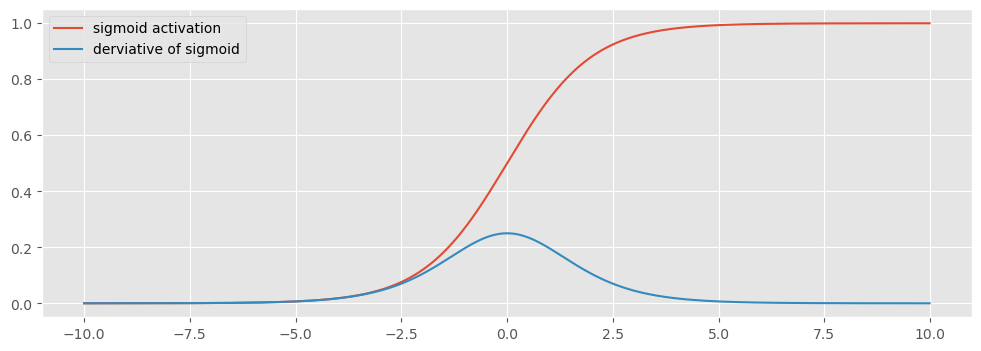

In [13]:
def plot_sigmoid_and_grad(resolution=0.01):
    x = np.arange(-10, 10, resolution)
    sigmoid = 1 / (1 + np.exp(-x))
    sigmoid_grad = sigmoid * (1 - sigmoid)
    
    print(f'min-max values of sigmoid : {np.min(sigmoid):.4f} | {np.max(sigmoid):.4f}')
    print(f'min-max values of dervivative of sigmoid : {np.min(sigmoid_grad):.4f} | {np.max(sigmoid_grad):.4f}')
    plt.figure(figsize=(12, 4))
    plt.plot(x, sigmoid, label='sigmoid activation')
    plt.plot(x, sigmoid_grad, label='derviative of sigmoid')
    plt.legend();

plot_sigmoid_and_grad()

It can be seen the sigmoid $\sigma(x) \in(0,1)$ and derivative of sigmoid $\sigma(x) \in(0, 0.25)$. This leads the problem that gradient can have maximum magnitude that is $1/4^{th}$ of forward activations. For a deeper network with large number of layers, the gradients get mutliplied when backpropogation leading to progressively samller gradients. At some point they might reach close to zero causing *dead gradients*. This will lead to failure of model to converge.

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs : 0 | train loss : 2.3434 | val loss : 2.3363 | train_acc : 0.1104 | val_acc : 0.1292 | gpu usage : 0.0
Epochs : 10 | train loss : 2.3381 | val loss : 2.3619 | train_acc : 0.0943 | val_acc : 0.0970 | gpu usage : 0.0
Epochs : 20 | train loss : 2.3356 | val loss : 2.3006 | train_acc : 0.1079 | val_acc : 0.1204 | gpu usage : 0.0
Epochs : 30 | train loss : 2.3336 | val loss : 2.3269 | train_acc : 0.1018 | val_acc : 0.1064 | gpu usage : 0.0
Epochs : 40 | train loss : 2.3267 | val loss : 2.3444 | train_acc : 0.1024 | val_acc : 0.0814 | gpu usage : 0.0
Epochs : 50 | train loss : 2.3299 | val loss : 2.3038 | train_acc : 0.1021 | val_acc : 0.1770 | gpu usage : 0.0
Epochs : 60 | train loss : 2.3203 | val loss : 2.2952 | train_acc : 0.1138 | val_acc : 0.1315 | gpu usage : 0.0
Epochs : 70 | train loss : 2.3266 | val loss : 2.3303 | train_acc : 0.0947 | val_acc : 0.0735 | gpu usage : 0.0
Epochs : 80 | train loss : 2.3265 | val loss : 2.3359 | train_acc : 0.1002 | val_acc : 0.1136 | gpu usage

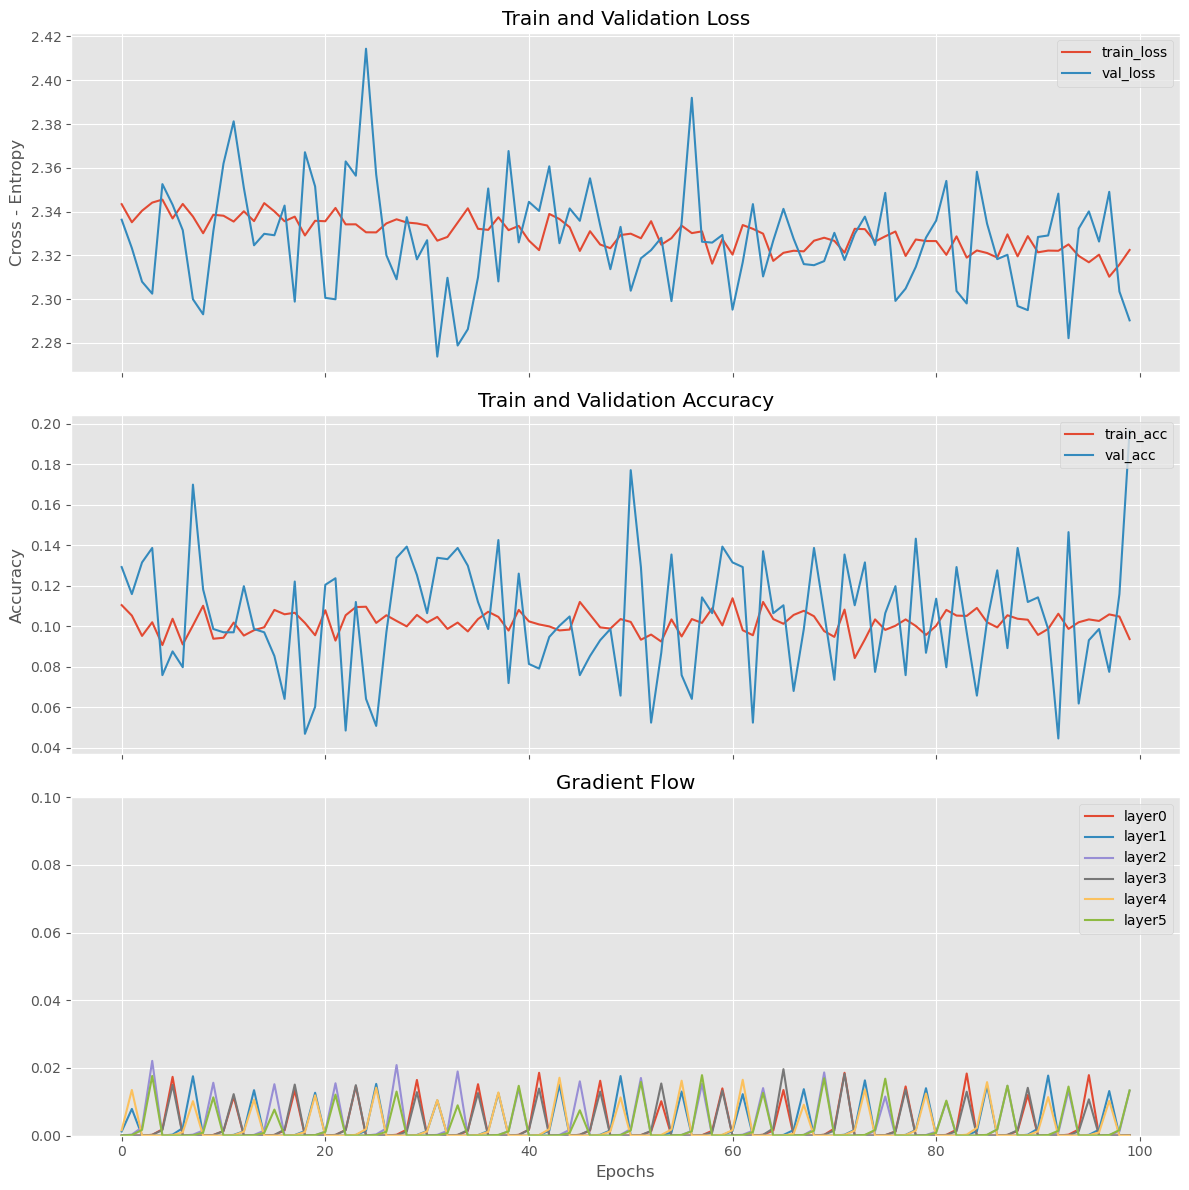

In [14]:
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=4, activation='sigmoid')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, dataset, batch_size=128, epochs = 100)
trainer.train()
trainer.plot_results(ylim=0.1)

It can be seen the gradients are very small leading to very slow convergence of network.

##### Model with ReLU activations

To solve the problem of vanishing gradients, a new non-linearity, "Rectified Linear Units" (ReLU) was proposed. ReLU: <br><br>
$R(x) = max(0,x)\qquad \in [0,\infin)$<br><br>
and derivative of ReLU:<br><br>
$R'(x) =
\begin{cases} 
0 & \text{if  }  x < 0 \\
1 & \text{if  }  x > 0 \\
\end{cases} 
$<br><br>
And undefined in $x=0$

min-max values of relu : 0.0000 | 1.9900
min-max values of dervivative of relu : 0.0000 | 1.0000


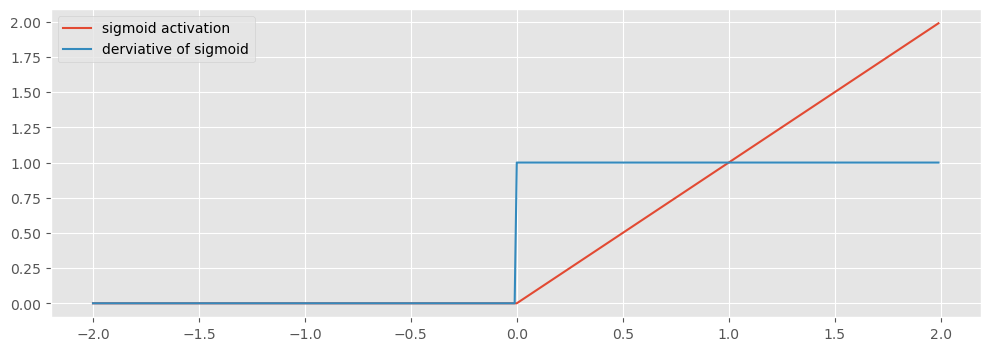

In [15]:
def plot_relu_and_grad(resolution=0.01):
    x = np.arange(-2, 2, resolution)
    relu = np.maximum(x, 0)
    relu_grad = np.where(relu <= 0, 0, 1)
    
    print(f'min-max values of relu : {np.min(relu):.4f} | {np.max(relu):.4f}')
    print(f'min-max values of dervivative of relu : {np.min(relu_grad):.4f} | {np.max(relu_grad):.4f}')
    plt.figure(figsize=(12, 4))
    plt.plot(x, relu, label='sigmoid activation')
    plt.plot(x, relu_grad, label='derviative of sigmoid')
    plt.legend();

plot_relu_and_grad()

It can be oberved that multiplying a bunch of RELU derivatives together in the backprop equations has the nice property of being either 1 or zero - the update is either nothing, or takes contributions entirely from the other weights and biases.<br><br>
In case of some ReLU function dying out, i.e there inputs being always negative leading to zero output, can generate sparse networks with a relatively small number of useful links. This in practise has been found to induce *regularization* which can be useful.<br><br>
Paper : https://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs : 0 | train loss : 2.4477 | val loss : 2.3182 | train_acc : 0.1002 | val_acc : 0.1425 | gpu usage : 0.0
Epochs : 10 | train loss : 2.2048 | val loss : 2.2351 | train_acc : 0.1829 | val_acc : 0.1510 | gpu usage : 0.0
Epochs : 20 | train loss : 2.0754 | val loss : 2.1425 | train_acc : 0.2353 | val_acc : 0.1712 | gpu usage : 0.0
Epochs : 30 | train loss : 1.9831 | val loss : 2.0351 | train_acc : 0.2679 | val_acc : 0.2590 | gpu usage : 0.0
Epochs : 40 | train loss : 1.8449 | val loss : 1.8606 | train_acc : 0.3690 | val_acc : 0.3905 | gpu usage : 0.0
Epochs : 50 | train loss : 1.6216 | val loss : 1.6280 | train_acc : 0.4675 | val_acc : 0.4155 | gpu usage : 0.0
Epochs : 60 | train loss : 1.4651 | val loss : 1.5219 | train_acc : 0.4827 | val_acc : 0.4741 | gpu usage : 0.0
Epochs : 70 | train loss : 1.3379 | val loss : 1.2559 | train_acc : 0.5358 | val_acc : 0.5815 | gpu usage : 0.0
Epochs : 80 | train loss : 1.1833 | val loss : 1.1322 | train_acc : 0.5979 | val_acc : 0.6284 | gpu usage

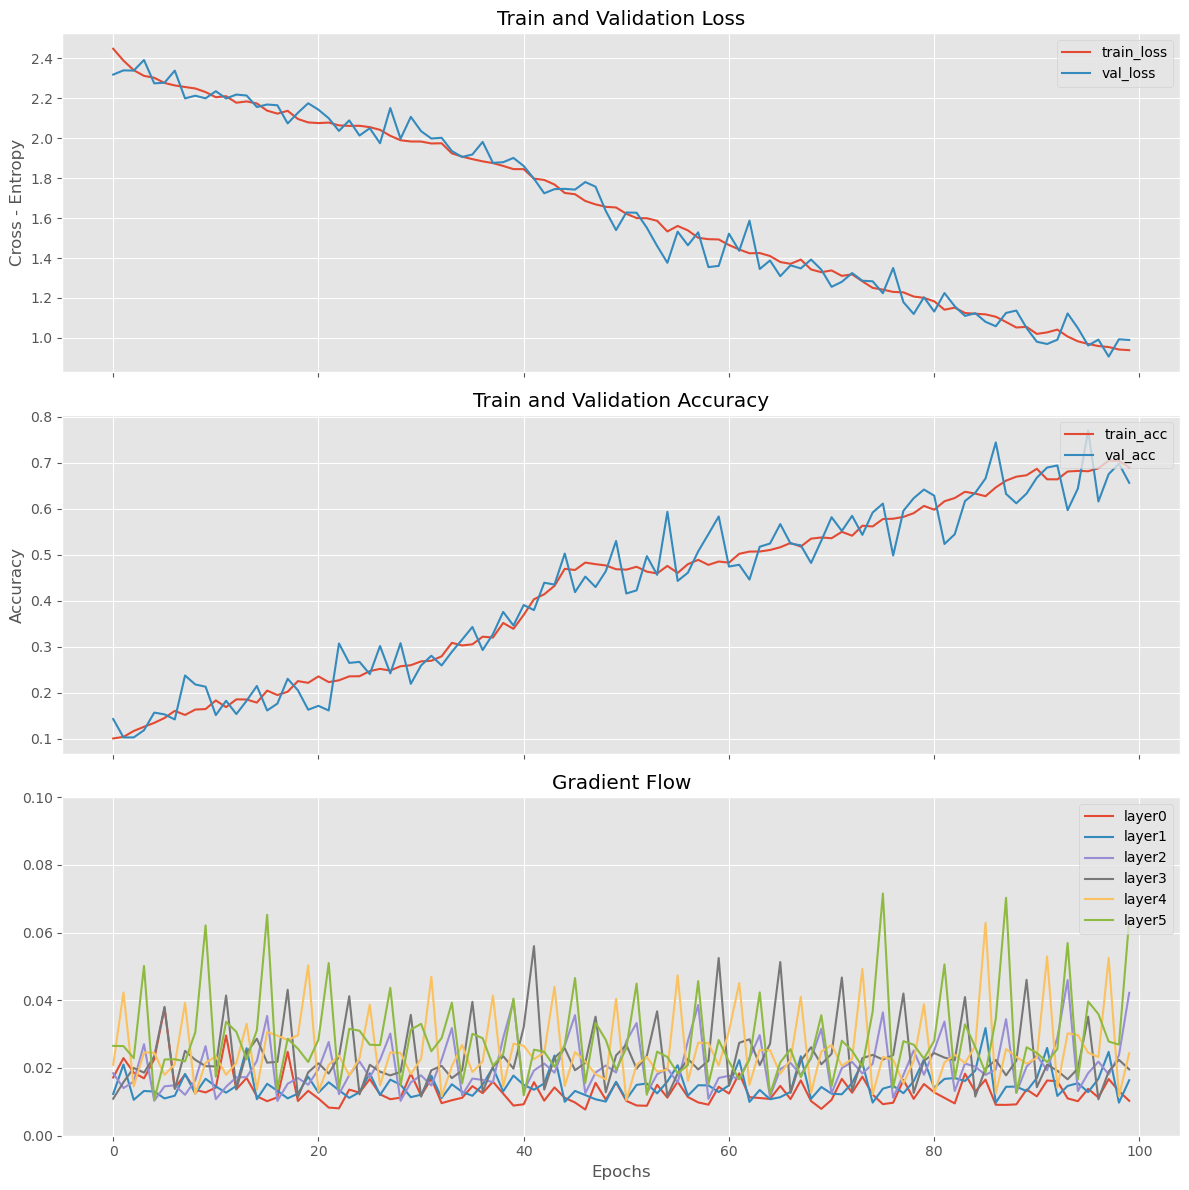

In [16]:
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=4, activation='relu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, dataset, batch_size=128, epochs = 100)
trainer.train()
trainer.plot_results(ylim=0.1)

ReLU activation lead to larger gradients than sigmoid activation, but is can be that with residual connections make gradient flow even better as shown in later sections.

#### Shattered Gradients

The results in paper mentioned below were failed to be replicated, so look for the results in paper. <br>
Paper : https://arxiv.org/pdf/1702.08591 <br><br>
The main findings in this paper are
- For a shallow network, the gradient of the output with respect to the input changes slowly as the input is changed.
- However for a deep netwrok, a tiny change in the input results in huge changes in gradients.
- This is captured by the autocorrelation function of the gradients. Nearby gradients are correlated for shallow networks, but this correlation quickly drops
to zero for deep networks. This is termed the shattered gradients phenomenon. 

### Residual Networks

In traditional feedforward neural networks, data flows through each layer sequentially: The output of a layer is the input for the next layer.

Residual connection provides another path for data to reach latter parts of the neural network by skipping some layers. Consider a sequence of layers, layer *i* to layer *i + n*, and let F be the function represented by these layers. Denote the input for layer *i* by *x*. In the traditional feedforward setting, *x* will simply go through these layers one by one, and the outcome of layer *i + n* is *F(x)*. A residual connection that bypasses these layers typically works as follows

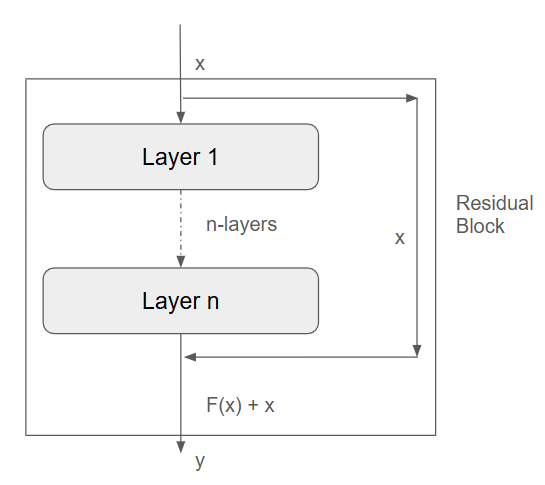

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers) -> None:
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.in_proj = nn.Linear(input_dim, hidden_dim)
        self.get_res_blocks(hidden_dim, num_layers)
        self.out_proj = nn.Linear(hidden_dim, output_dim)

    def get_res_blocks(self, hidden_dim, num_layers):
        self.res_blocks = nn.ModuleList()
        for _ in range(num_layers):
            self.res_blocks.extend([
                nn.Linear(hidden_dim, hidden_dim),
                self.act
                ])

    def get_activations(self, layer, x):            
        if isinstance(layer, nn.Linear):
            self.activations_state_dict.append(x.detach().cpu().abs().mean().numpy())
   
    def forward(self, x):
        x = self.in_proj(x)  
        x_skip = torch.clone(x)
        for layer in self.res_blocks:
            x = layer(x)
        x = x + x_skip
        x = self.out_proj(x)
        return x


num_classes = np.unique(data[:, 0])
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=4)
print(
    f'model output shape : {model(dataset[0][0]).shape}',
    f'\nnum parameters in model : {sum(p.numel() for p in model.parameters())}'
    )

model output shape : torch.Size([10]) 
num parameters in model : 17590


In [18]:
model = MLP(input_dim=784, hidden_dim=20, output_dim=len(num_classes), num_layers=8)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, dataset, batch_size=128, epochs = 100)
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs : 0 | train loss : 120.5259 | val loss : 278.9688 | train_acc : 0.2121 | val_acc : 0.2714 | gpu usage : 0.0
Epochs : 10 | train loss : 0.8193 | val loss : 0.4736 | train_acc : 0.9314 | val_acc : 0.9265 | gpu usage : 0.0
Epochs : 20 | train loss : 0.1018 | val loss : 0.2952 | train_acc : 0.9875 | val_acc : 0.9828 | gpu usage : 0.0
Epochs : 30 | train loss : 0.0013 | val loss : 0.0013 | train_acc : 1.0000 | val_acc : 1.0000 | gpu usage : 0.0
Epochs : 40 | train loss : 0.0010 | val loss : 0.0005 | train_acc : 1.0000 | val_acc : 1.0000 | gpu usage : 0.0
Epochs : 50 | train loss : 0.0007 | val loss : 0.0007 | train_acc : 1.0000 | val_acc : 1.0000 | gpu usage : 0.0
Epochs : 60 | train loss : 0.0006 | val loss : 0.0004 | train_acc : 1.0000 | val_acc : 1.0000 | gpu usage : 0.0
Epochs : 70 | train loss : 0.0005 | val loss : 0.0007 | train_acc : 1.0000 | val_acc : 1.0000 | gpu usage : 0.0
Epochs : 80 | train loss : 0.0005 | val loss : 0.0009 | train_acc : 1.0000 | val_acc : 1.0000 | gpu u

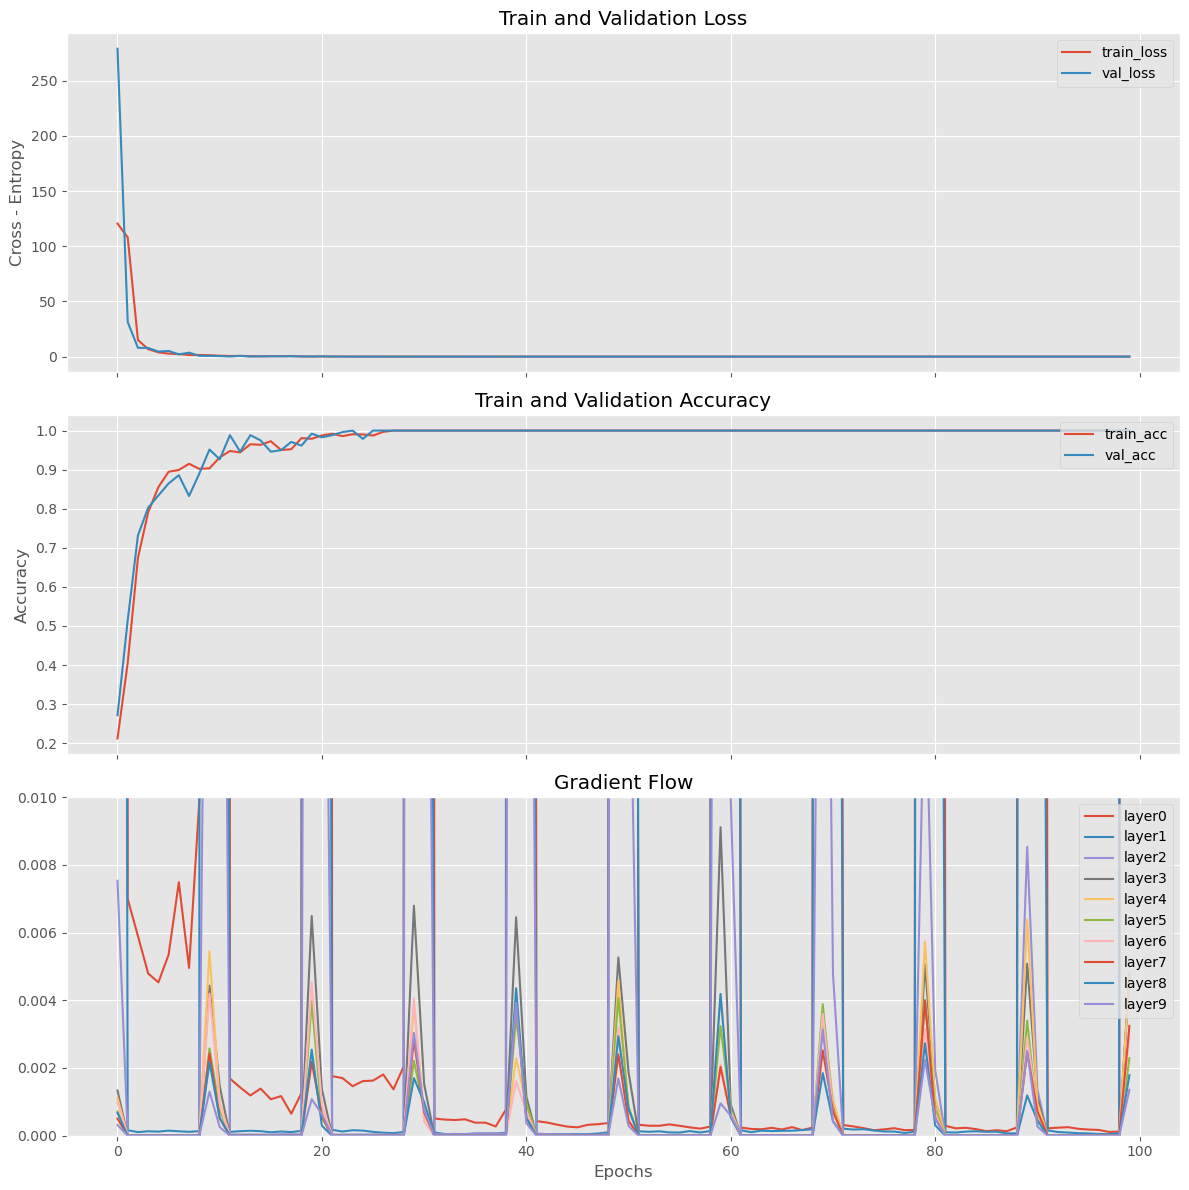

In [19]:
trainer.plot_results(ylim=0.01)

`Observations`:
- Model Converges way faster (even faster than shallow network).
- The magnitude of gradients is larger compared to gradients seen before,  *mitigating vanishing gradients.*

### Reasons why Residual connection works

#### Behaving like Ensembles of shallow neural networks

Paper : https://arxiv.org/pdf/1605.06431

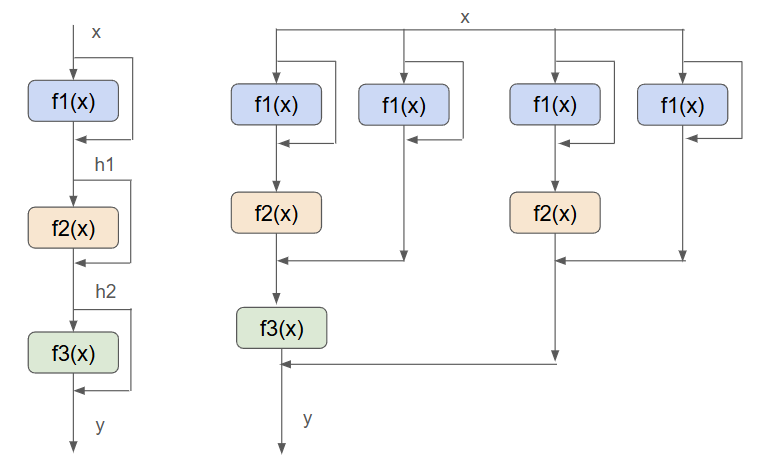

Forward Pass Equations for network consisting of three residual blocks.<br>
$h_1 = f_1(x) + x \qquad	h_2 = f_2(h_1) + h_1	\qquad y = f_3(h_2) + h_2$<br><br>
Applying Backward Substitution:<br>
$y = x + f_1(x)\\
\qquad + f_2(x + f_1(x))\\
\qquad + f_3(x + f_1(x) + f_2(x + f_1(x)))
$
<br><br>
The figure is representation of equation obtained after backward substitution.
There are $2^3=8$ terms of the input x that contribute to the output $y$. Hence, we can also view this network as a collection of 8 paths, of lengths 0, 1, 2 and 3, as illustrated in the figure above.<br>
Under this "unraveled view", above shows that networks with residual connections behave like ensembles of networks that do not strongly depend on each other. Moreover, most of the gradient during gradient descent training comes from short paths. In other words, residual connection does not resolve the exploding or vanishing gradient problems. Rather, it avoids those problems by having shallow networks in the **"ensembles"**.


#### Shattered Gradients

For a deep neural network without any residual connections, derivative w.r.t to $f_1$ looks like:<br><br>
$\frac{\partial y}{\partial f_1} = \frac{\partial y}{\partial f_3} \times \frac{\partial f_3}{\partial f_2} \times \frac{\partial f_2}{\partial f_1} $<br><br>
For a deep neural network with any residual connections, derivative w.r.t to $f_1$ looks like:<br><br>
$
\frac{\partial y}{\partial f_1} = I + \frac{\partial f_2}{\partial f_1} + \frac{\partial f_3}{\partial f_1} + 
(\frac{\partial f_2}{\partial f_1}\cdot\frac{\partial f_3}{\partial f_2})
$<br><br>
In earlier section, it was observed that the gradients for shallow network were well behaved. In model with residual connections, we have identity term and shorter paths contribute to the gradients of each layer, causing model to suffer less with shattered gradient.

### Backward Pass Illustration

For model with single hidden layer and no residual connection:<br><br>
$\frac {\partial y}{\partial x} = \frac {\partial y}{\partial F} \times \frac{\partial F}{\partial x}$<br><br>
For model with single hidden layer and residual connection where $h(x) = f(x) + x$:<br><br>
$\frac {\partial y}{\partial x} = \frac {\partial y}{\partial H}\times \frac{\partial H}{\partial x} = \frac {\partial y}{\partial H} \times (\frac{\partial F}{\partial  x} + 1) = \frac {\partial y}{\partial H} \times \frac{\partial F}{\partial x} + \frac {\partial y}{\partial H} $<br><br>
This ensures that even if $ \frac {\partial F}{\partial x}  \to 0$, the gradients do not vanish for a residual block.